In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
cle.select_device('RTX')
print("Using OpenCL device " + cle.get_device().name)

import math
import numpy as np
import pandas as pd
import cv2
import tifffile
import os
import nrrd

from oiffile import OifFile
from src.OifImageViewer import OifImageViewer

Using OpenCL device NVIDIA RTX A5000


In [2]:
path = "/home/dkermany/data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20210112_164055.oib"
filename = os.path.splitext(os.path.basename(path))[0]

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)
    x_step, y_step, z_step = map(float, (viewer.md["x_step"], viewer.md["y_step"], viewer.md["z_step"]))
    if viewer.md["z_unit"] == "nm":
        z_step /= 1000.

Image shape: (3, 92, 3012, 13421)
Axes: CZYX
Dtype: uint16
Intervals: X (0.621um) Y (0.621um) Z (3140nm)



Load 3D Masks
----------------------

(92, 3012, 13421)
uint16


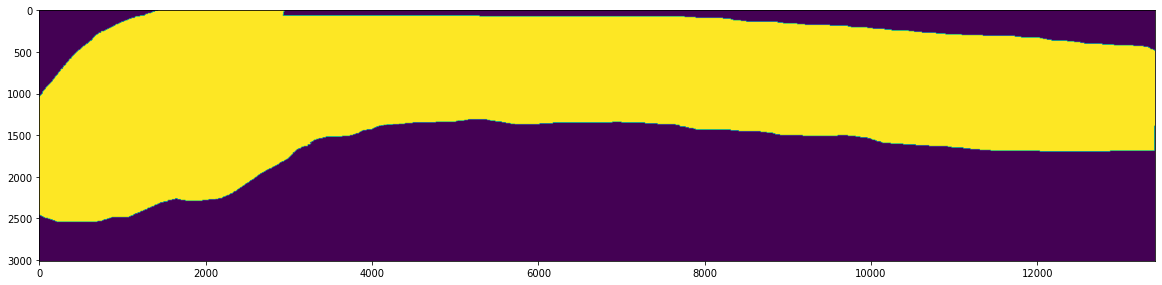

In [3]:
mask_path = f"/home/dkermany/data/Bone_Project/masks/{filename}.seg.nrrd"

# Load mask from NRRD
mask, header = nrrd.read(mask_path)
mask = mask.T
# mask = mask[:mask.shape[0]//3, :, :] #For FV10__20190620_111343

# Convert mask from uint8 to uint16
mask = mask.astype(np.uint16)
mask *= 2**16 - 1
print(mask.shape)
print(mask.dtype)

plt.figure(figsize=(20,20))
plt.imshow(mask[40])

In [4]:
tumor_csv_path = "/home/dkermany/data/Bone_Project/tumor_locations_02_08_2023.csv"
# Load csv and drop rows with N/A's
tumor_csv = pd.read_csv(tumor_csv_path).dropna()
tumor_csv

Filename  x (um)  y (um)  z (slice)
0    FV10__20190620_111343  2987.0  1760.0       76.0
1    FV10__20190620_111343  2975.0  1755.0       76.0
2    FV10__20190620_111343  2953.0  1715.0       76.0
3    FV10__20190620_111343  3079.0  1680.0       76.0
4    FV10__20190620_111343  2815.0  1342.0       76.0
..                     ...     ...     ...        ...
818  FV10__20190619_111005  6508.0  1024.0       31.0
819  FV10__20190619_111005  6516.0   947.0       32.0
820  FV10__20190619_111005  6211.0  1197.0       31.0
821  FV10__20190619_111005  6565.0  1229.0       35.0
822  FV10__20190619_111005  6274.0  1236.0       23.0

[816 rows x 4 columns]


Tumor Location Marking
----------------------

In [5]:
# Filter tumors for the image in focus
tumor_csv = tumor_csv[tumor_csv.Filename == filename].reset_index(drop=True)
tumor_csv

Empty DataFrame
Columns: [Filename, x (um), y (um), z (slice)]
Index: []

In [6]:
tumor_dict = tumor_csv.to_dict("index")
tumor_dict

{}

In [7]:
len(tumor_dict)

0

To calculate the radius of a circle formed by looking at a z-slice of a sphere, you can use the following formula:

radius = sqrt(r^2 - z^2)

where r is the radius of the sphere and z is the distance from the center of the sphere to the z-slice. This formula assumes that the z-slice is perpendicular to the center of the sphere.

For example, suppose you have a sphere with a radius of 5 units and you want to find the radius of the circle formed by a z-slice that is 2 units away from the center of the sphere. In this case, you would plug the values into the formula like this:

radius = sqrt(5^2 - 2^2)
= sqrt(25 - 4)
= sqrt(21)
= 3.605551275463989

So the radius of the circle would be approximately 3.61 units.

In [8]:
# tumor_labels = np.zeros(viewer._arr.shape[1:], dtype=np.uint16)

# for idx, tumor_info in tumor_dict.items():
#     x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
#     x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
#     print(x, y, z)
    
#     sphere_radius = 7 # micron
#     sphere_z_slices = math.ceil(sphere_radius / z_step)
    
#     min_z_step = max(0, z-sphere_z_slices)
#     max_z_step = min(z+sphere_z_slices, viewer._arr.shape[1])

#     # Label tumor
#     for z_prime in range(min_z_step, max_z_step):
#         cv2.circle(
#             tumor_labels[z_prime],
#             (x, y),
#             radius=round((sphere_radius**2 - min((z_step*abs(z_prime-z))**2, sphere_radius**2))**0.5),
#             color=(4096,4096,4096),
#             thickness=-1,
#         )
# print(tumor_labels.shape)

In [9]:
# total_image = np.concatenate((viewer._arr, np.expand_dims(tumor_labels, axis=0)), axis=0)
# print(total_image.shape)
# print("Total Image type:", total_image.dtype)

In [10]:
def dict_to_pointlist(dict: tumor_dict) -> np.ndarray:
    pointlist = np.zeros((3, len(tumor_dict)))
    for idx, tumor_info in tumor_dict.items():
        x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
        x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
        
        pointlist[0][idx] = x
        pointlist[1][idx] = y
        pointlist[2][idx] = z
        
    return pointlist

In [11]:
tumor_pointlist = dict_to_pointlist(tumor_dict)
print(tumor_pointlist)

[]


Vessel Segmentation
-----------------------------

In [12]:
# original_vessels = cle.push(viewer.get_array()[2])
# plt.figure(figsize=(16,9))
# cle.imshow(original_vessels[40])

# masked_vessels = cle.mask(original_vessels, mask)
# plt.figure(figsize=(16,9))
# cle.imshow(masked_vessels[40])

# del original_vessels

In [13]:
# img_gaussian = cle.gaussian_blur(masked_vessels, sigma_x=2, sigma_y=2, sigma_z=2)
# backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

# plt.figure(figsize=(16,9))
# cle.imshow(backgrund_subtracted[40])

In [14]:
# thresh2 = cle.threshold_otsu(backgrund_subtracted)

# plt.figure(figsize=(16,9))
# cle.imshow(thresh2[40])

In [15]:
# Morphological openning
# erosion = cle.erode_box(thresh2)
# dilation = cle.dilate_box(erosion)

# plt.figure(figsize=(16,9))
# cle.imshow(dilation[40])

In [16]:
# del erosion, backgrund_subtracted, img_gaussian

In [17]:
# Convert dilation from uint8 to uint16
# dilation = dilation.astype(np.uint16)
# dilation *= 2**10 - 1 #2**16 - 1

# # Add vessel segmentation result to total_image
# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(dilation), axis=0)), axis=0)
# print(total_image.shape)
# print(total_image.dtype)

Find Vessel Bifurcations
----

In [18]:
from skimage.morphology import skeletonize_3d
# skeleton = skeletonize_3d(dilation)

# plt.figure(figsize=(30,20))
# cle.imshow(skeleton)

In [19]:
# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(skeleton), axis=0)), axis=0)
# del skeleton

NG2 Segmentation
---------------------------

In [22]:
original_ng2 = cle.push(viewer.get_array()[1])[:,:,:5000]
plt.figure(figsize=(16,9))
cle.imshow(original_ng2)

masked_ng2 = cle.mask(original_ng2, mask)
plt.figure(figsize=(16,9))
cle.imshow(masked_ng2)

del original_ng2

MemoryError: clEnqueueWriteBuffer failed: MEM_OBJECT_ALLOCATION_FAILURE

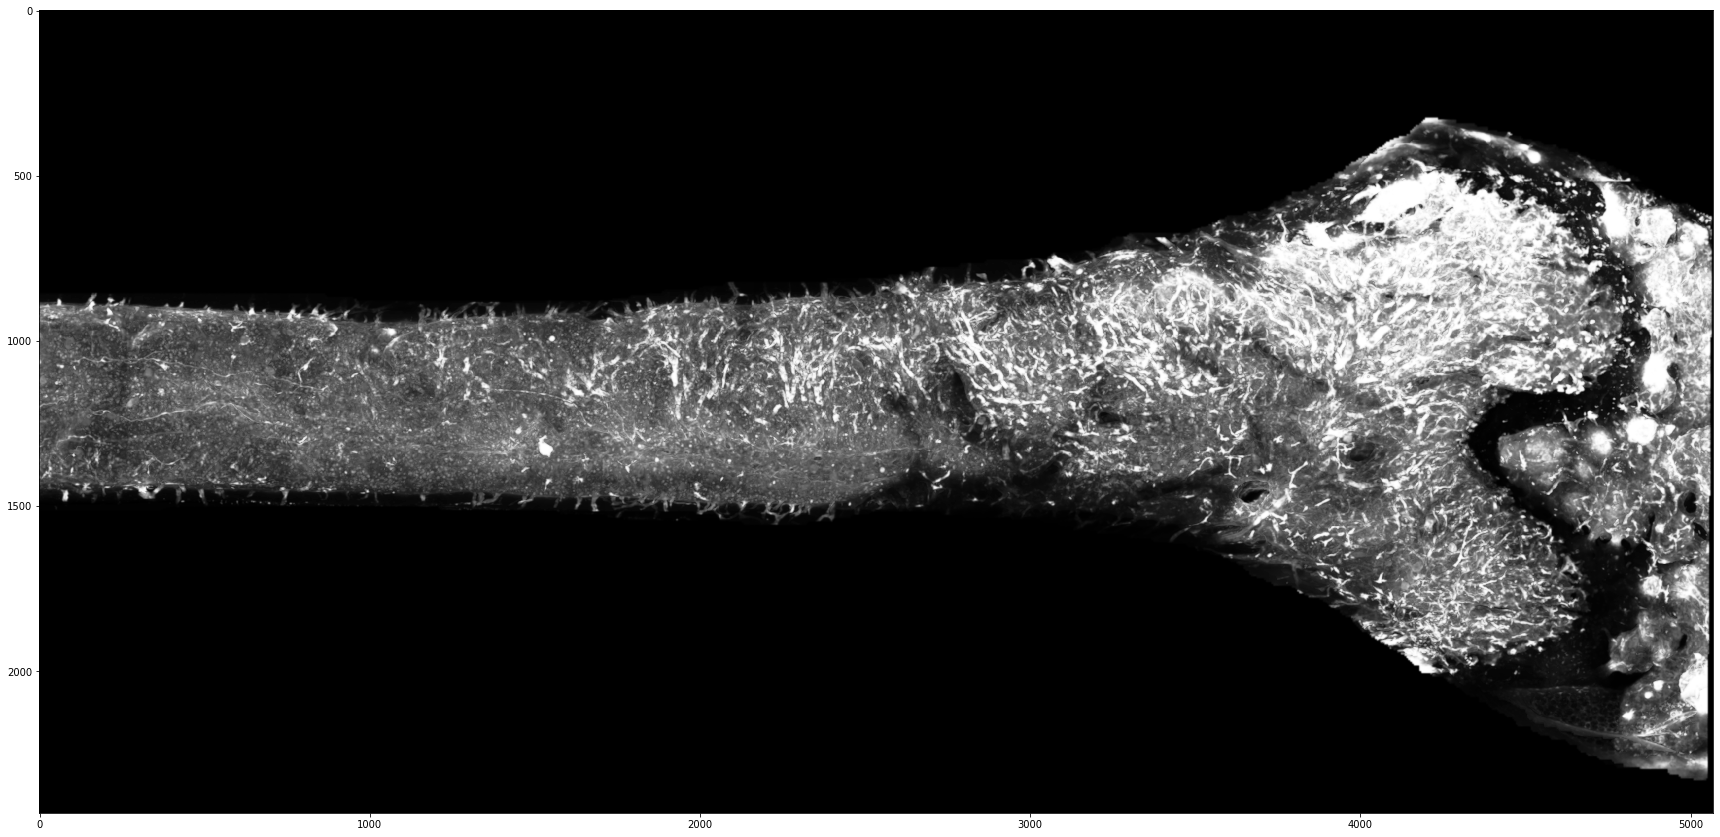

In [ ]:
img_gaussian = cle.gaussian_blur(masked_ng2, sigma_x=2, sigma_y=2, sigma_z=2)
plt.figure(figsize=(30,15))
cle.imshow(img_gaussian)

del masked_ng2

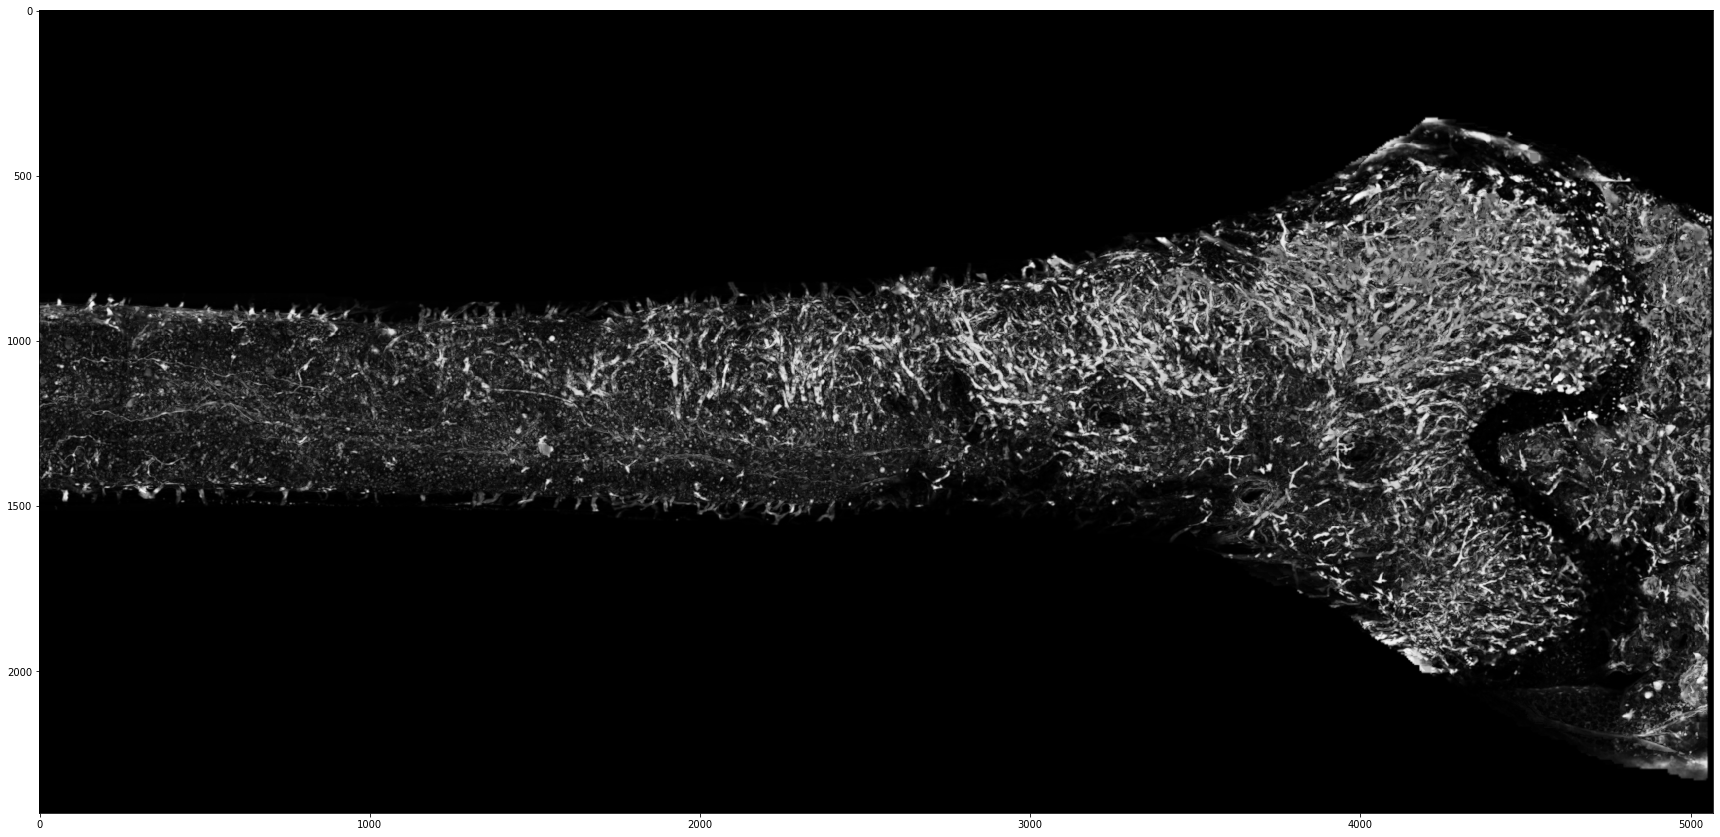

In [ ]:
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(30,15))
cle.imshow(backgrund_subtracted)

In [ ]:
filename

'FV10__20190619_111005'

In [1]:
# 1500  FV10__20190620_111343
# 1200  FV10__20181004_122358
# 1200  FV10__20181005_104242
# 1500 'FV10__20181008_104428'
# 1200  FV10__20181009_103052
# 1000 'FV10__20181106_121902'

thresh1 = np.where(backgrund_subtracted > 1200, 65535, 0)

plt.figure(figsize=(30,15))
cle.imshow(thresh1)

NameError: name 'np' is not defined

In [25]:
# thresh2 = cle.threshold_otsu(backgrund_subtracted)

# plt.figure(figsize=(30,15))
# cle.imshow(thresh2)

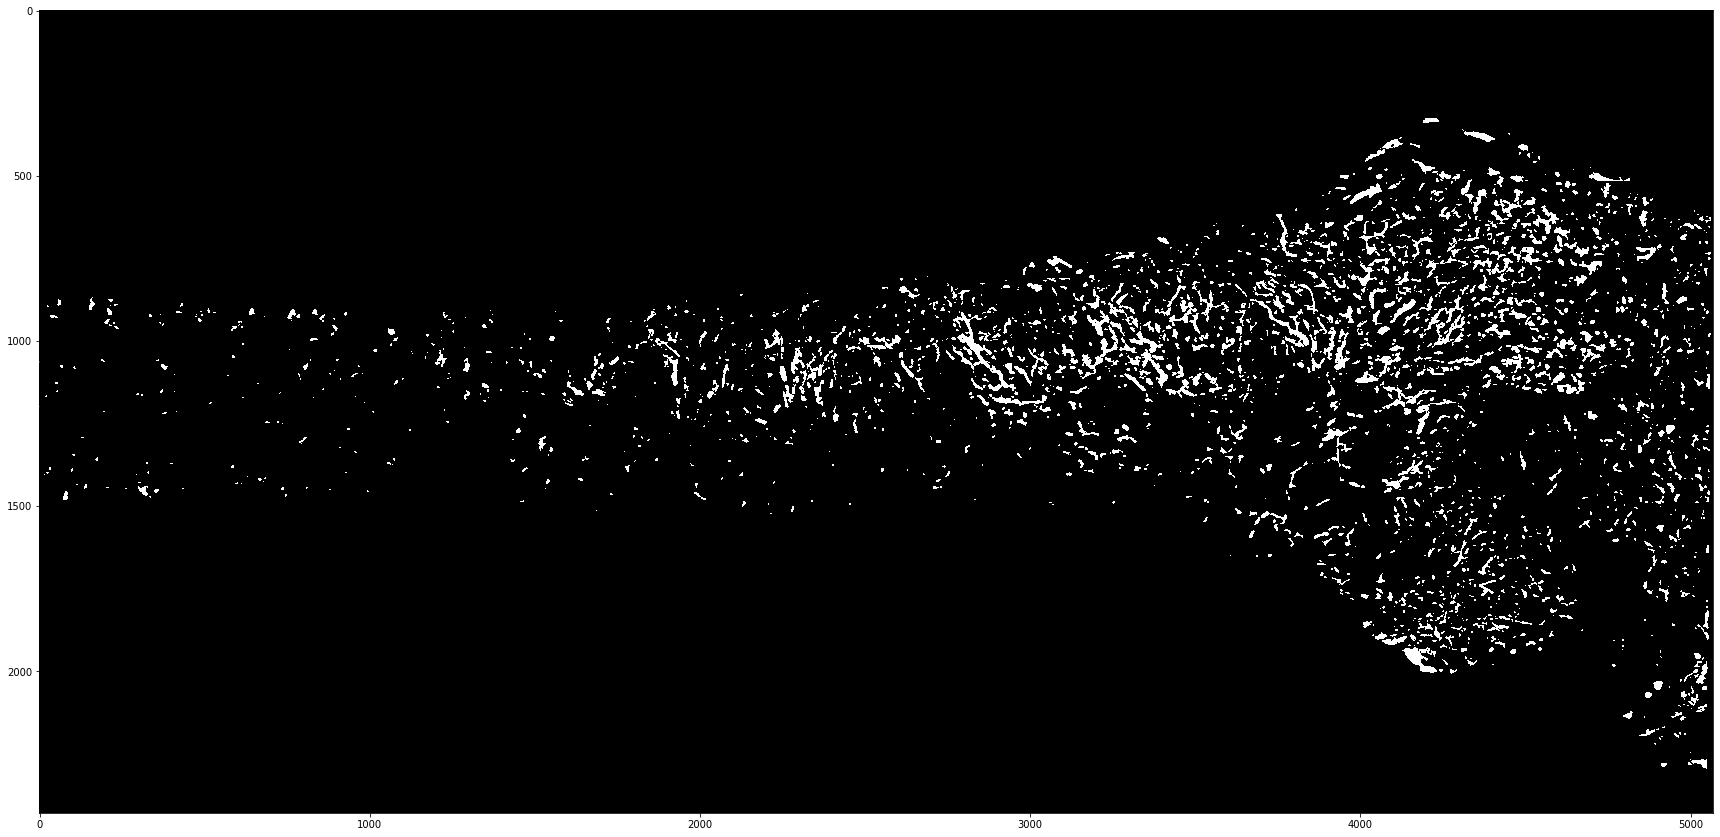

(95, 2430, 5070)


In [26]:
# Morphological opening
kernel = np.ones((5,5), np.uint8)
erosion = cle.erode_box(thresh1) #thresh2
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(30,15))
cle.imshow(dilation)
print(dilation.shape)

In [27]:
del erosion, thresh1, backgrund_subtracted, img_gaussian

(95, 2430, 5070)


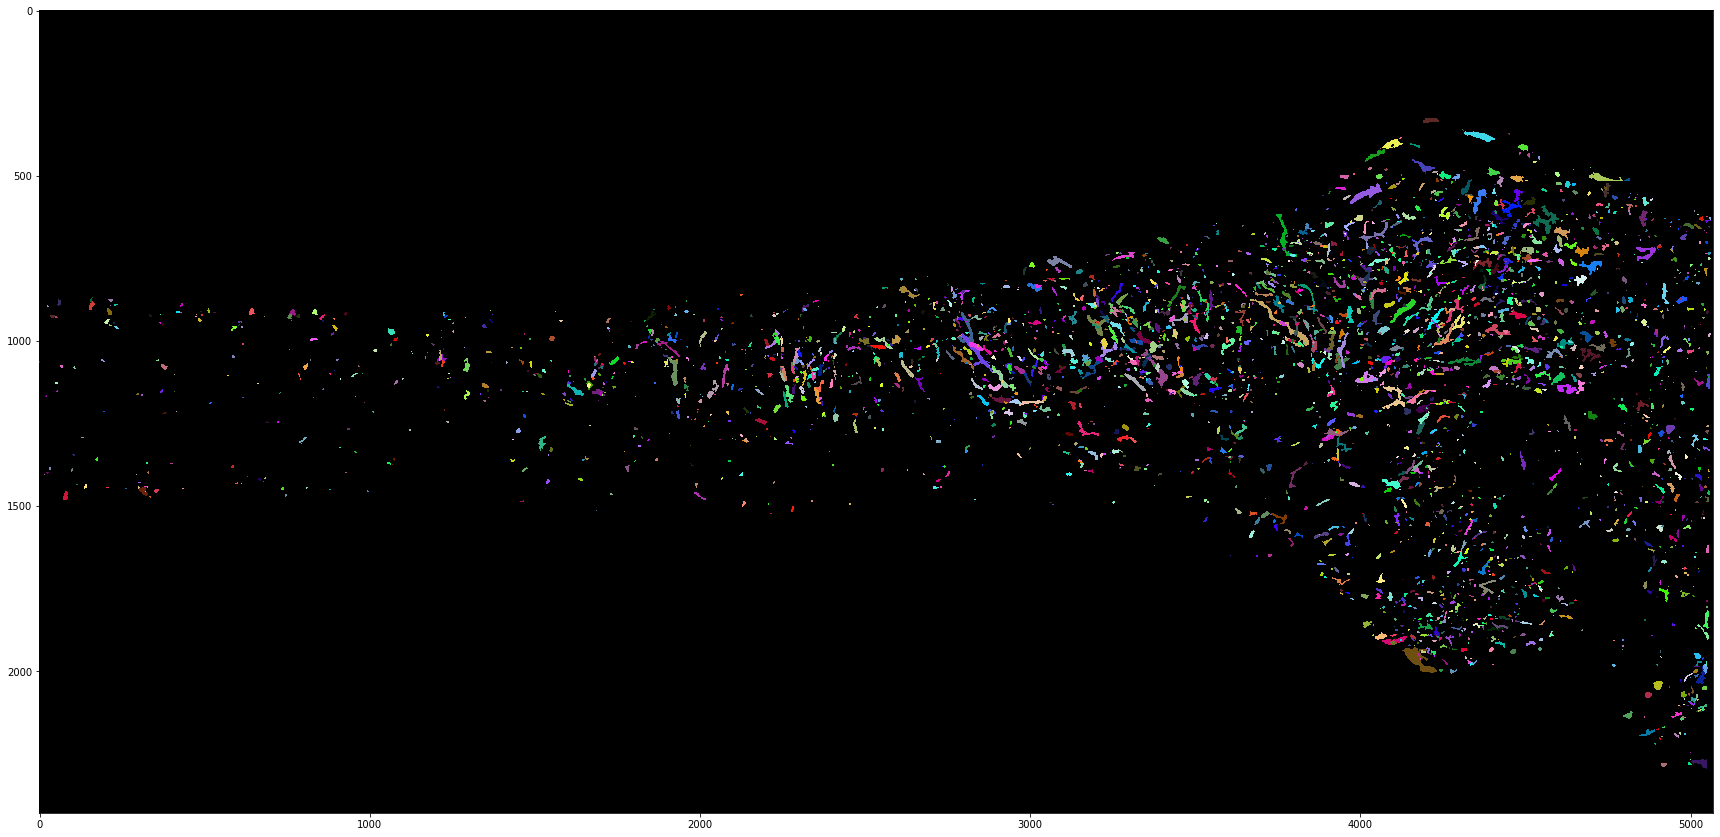

In [28]:
labels = cle.connected_components_labeling_box(dilation)
print(labels.shape)
plt.figure(figsize=(30,15))
cle.imshow(labels, labels=True)

In [28]:
filename

'FV10__20181008_104428'

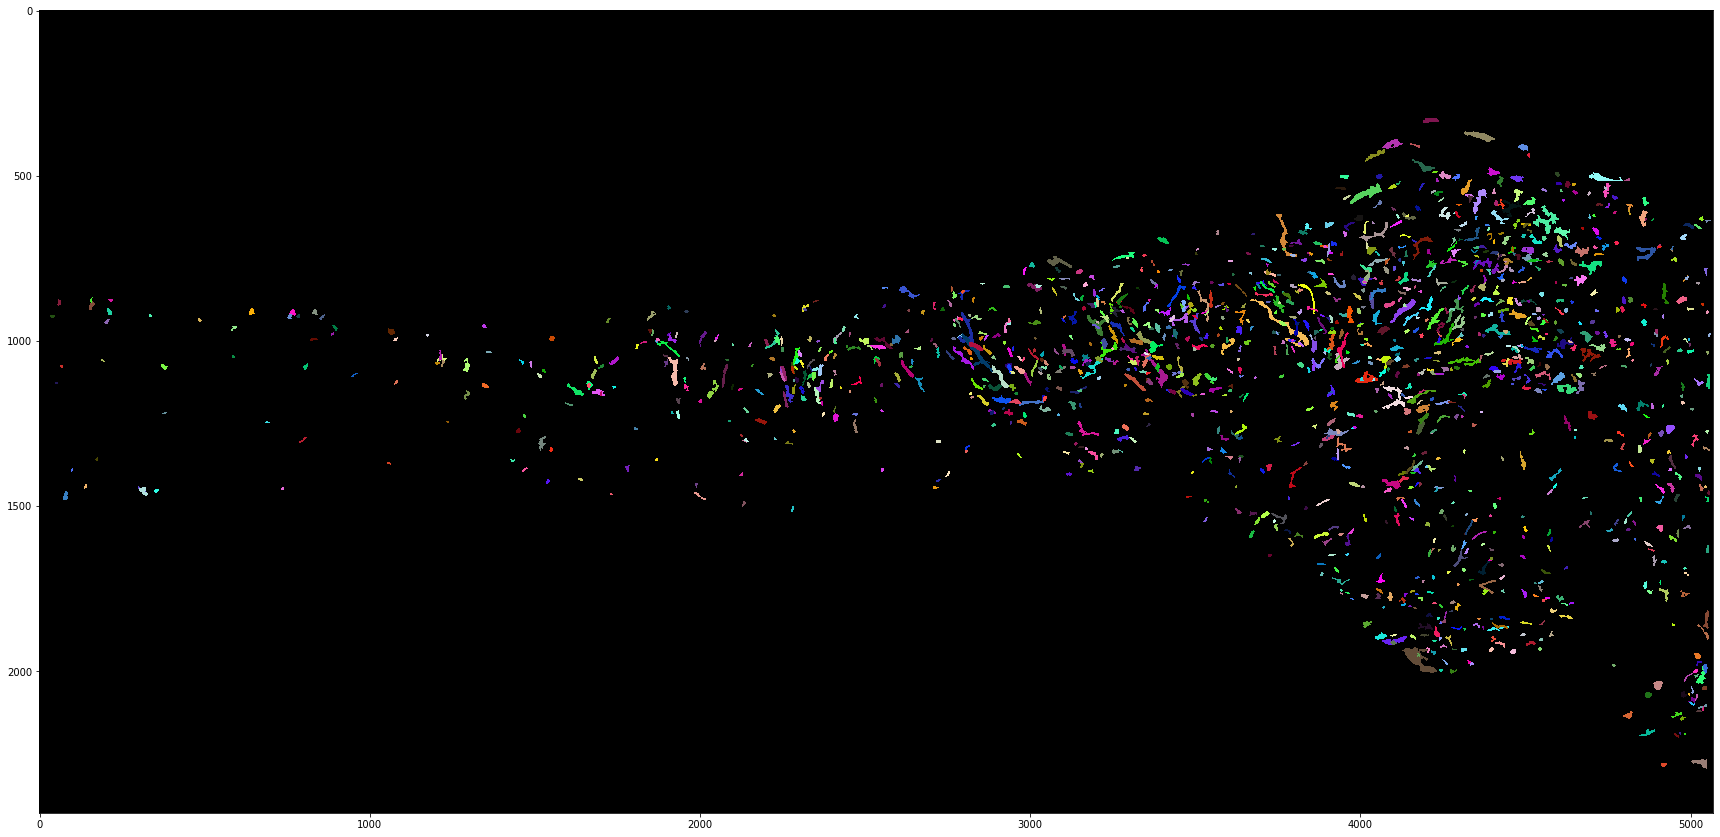

In [29]:
# Thresholds used
# 1000 
# 400 'FV10__20181004_122358'

smalls_filtered_out = cle.exclude_labels_outside_size_range(labels, None, 400, 100000)
plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out, labels=True)

In [30]:
a = cle.centroids_of_labels(smalls_filtered_out)
print(a.shape)


(3, 1414)


In [31]:
np.save(f"/home/dkermany/data/Bone_Project/NG2_Centroids/{filename}_NG2_centroids.npy", np.array(a))

In [23]:
print(filename)
!ls /home/dkermany/data/Bone_Project/NG2_Centroids/

FV10__20210112_164055
FV10__20181004_122358_NG2_centroids.npy
FV10__20181005_104242_NG2_centroids.npy
FV10__20181008_104428_NG2_centroids.npy
FV10__20181009_103052_NG2_centroids.npy
FV10__20181106_121902_NG2_centroids.npy
FV10__20181106_172421_NG2_centroids.npy
FV10__20190619_111005_NG2_centroids.npy
FV10__20190620_111343_NG2_centroids.npy


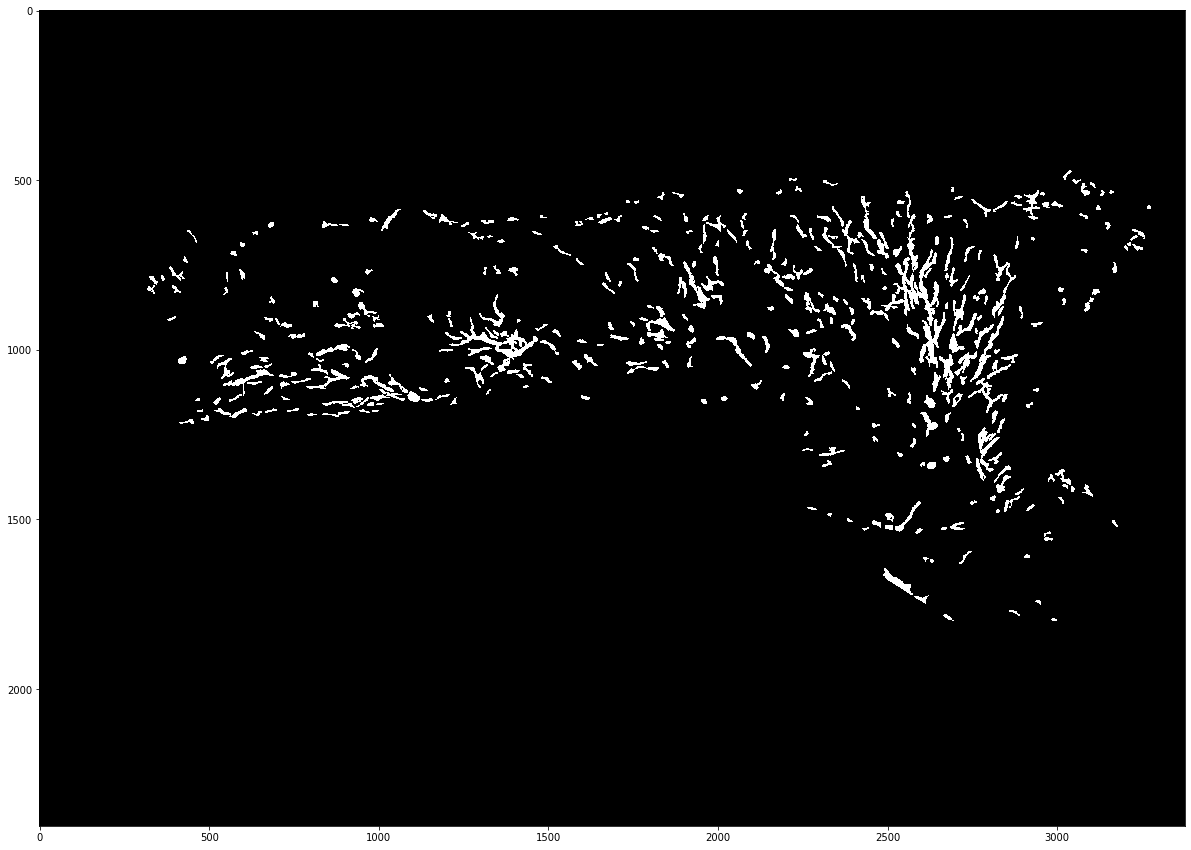

In [30]:
binarized_NG2 = 1 * (smalls_filtered_out > 0)
plt.figure(figsize=(30,15))
cle.imshow(binarized_NG2, labels=False)

In [31]:
print(np.unique(binarized_NG2))

total_image = np.concatenate((total_image, np.expand_dims(cle.pull(2000*binarized_NG2), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

[0 1]
(7, 76, 2404, 3376)
uint16


[0 1]


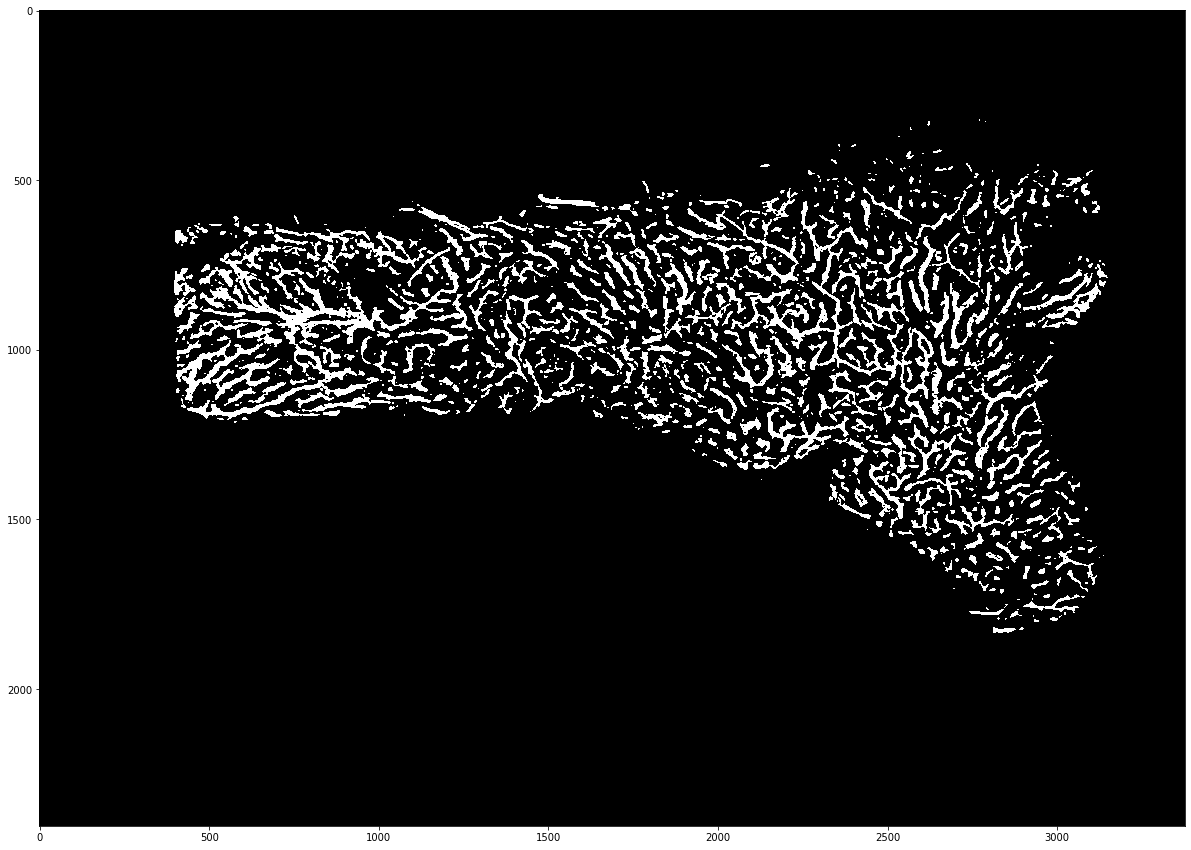

In [32]:
binarized_VESSEL = 1 * (total_image[4] > 0)
print(np.unique(binarized_VESSEL[40]))

plt.figure(figsize=(30,15))
cle.imshow(binarized_VESSEL[40], labels=False)

(76, 2404, 3376)


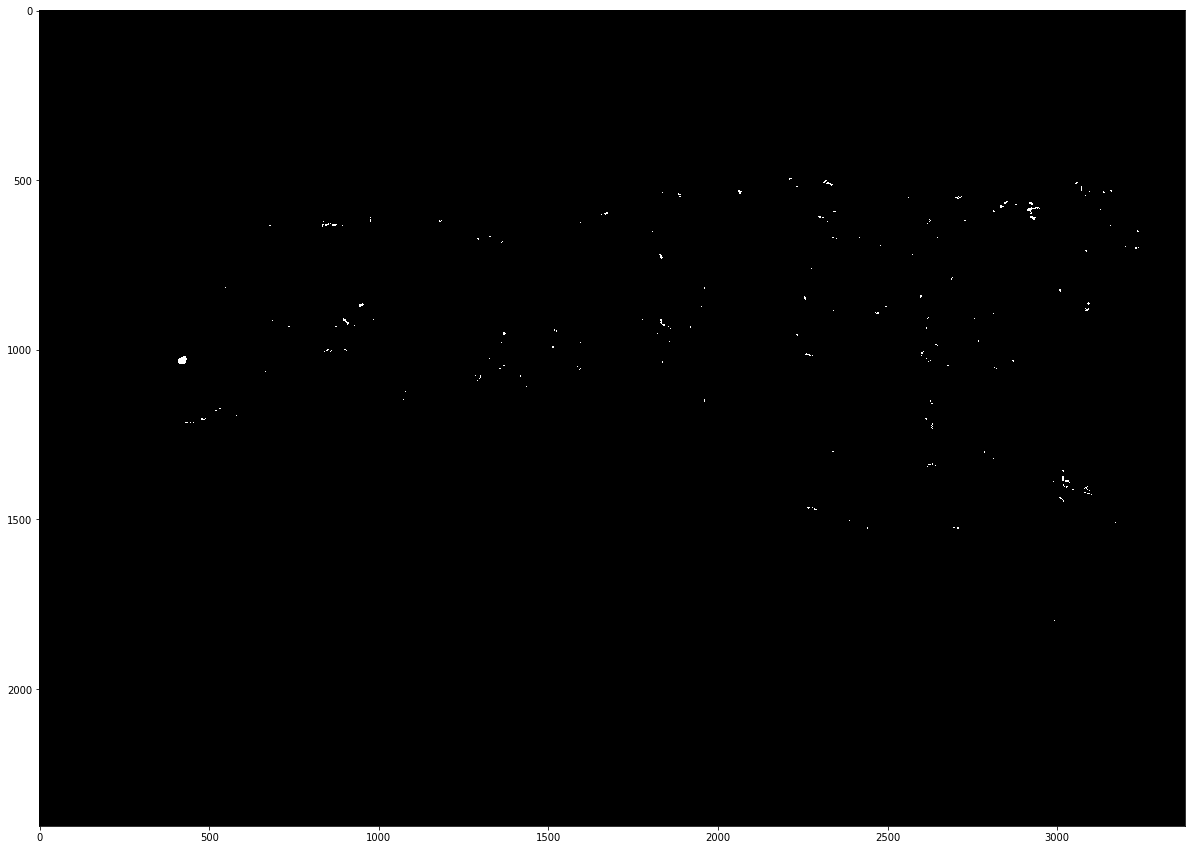

In [34]:
diff = binarized_NG2 - binarized_VESSEL
print(diff.shape)
diff = np.where(diff < 0, 0, diff)
np.unique(diff)
plt.figure(figsize=(30,15))
cle.imshow(diff, labels=False)

In [53]:
# Morphological opening
diff_erosion = cle.erode_box(diff)
diff_dilation = cle.dilate_box(diff_erosion)

plt.figure(figsize=(30,15))
cle.imshow(diff_dilation[40])
print(diff_dilation.shape)

NameError: name 'diff' is not defined

In [34]:
del diff_erosion, diff, binarized_VESSEL, binarized_NG2, labels, smalls_filtered_out

(76, 2404, 3376)


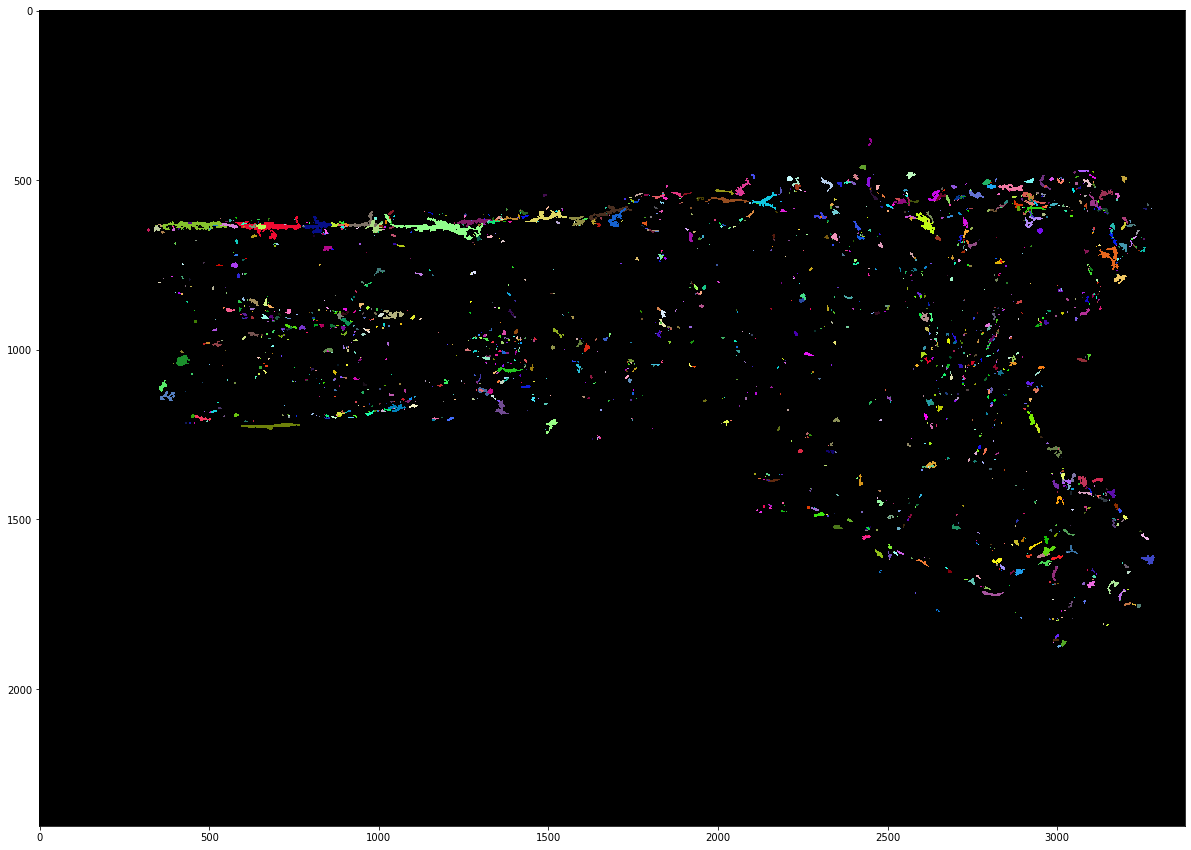

In [35]:
diff_labels = cle.connected_components_labeling_box(diff_dilation)
print(diff_labels.shape)
plt.figure(figsize=(30,15))
cle.imshow(diff_labels[40], labels=True)

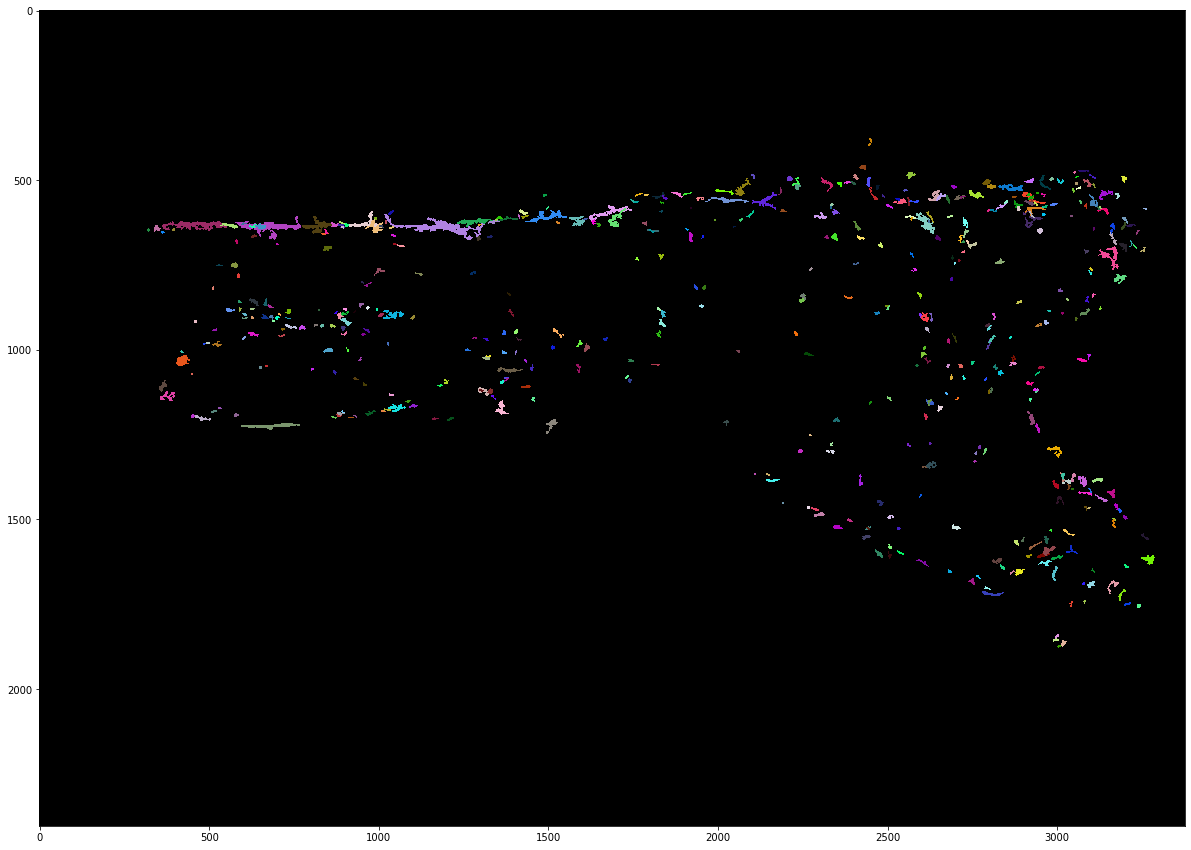

In [36]:
diff_smalls_filtered_out = cle.exclude_labels_outside_size_range(diff_labels, None, 256, 100000)
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out, labels=True)

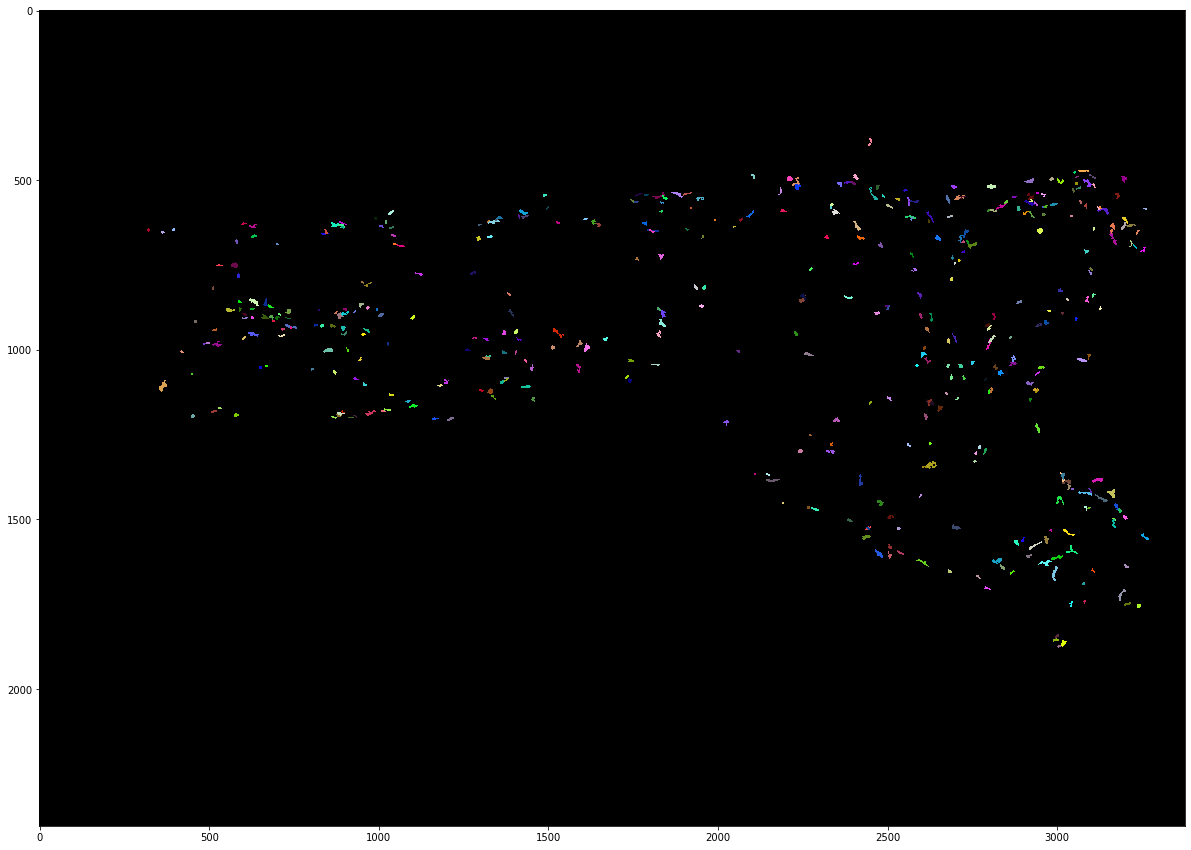

In [37]:
diff_smalls_filtered_out_x2 = cle.exclude_labels_outside_size_range(diff_labels, None, 256, 2000)
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out_x2, labels=True)

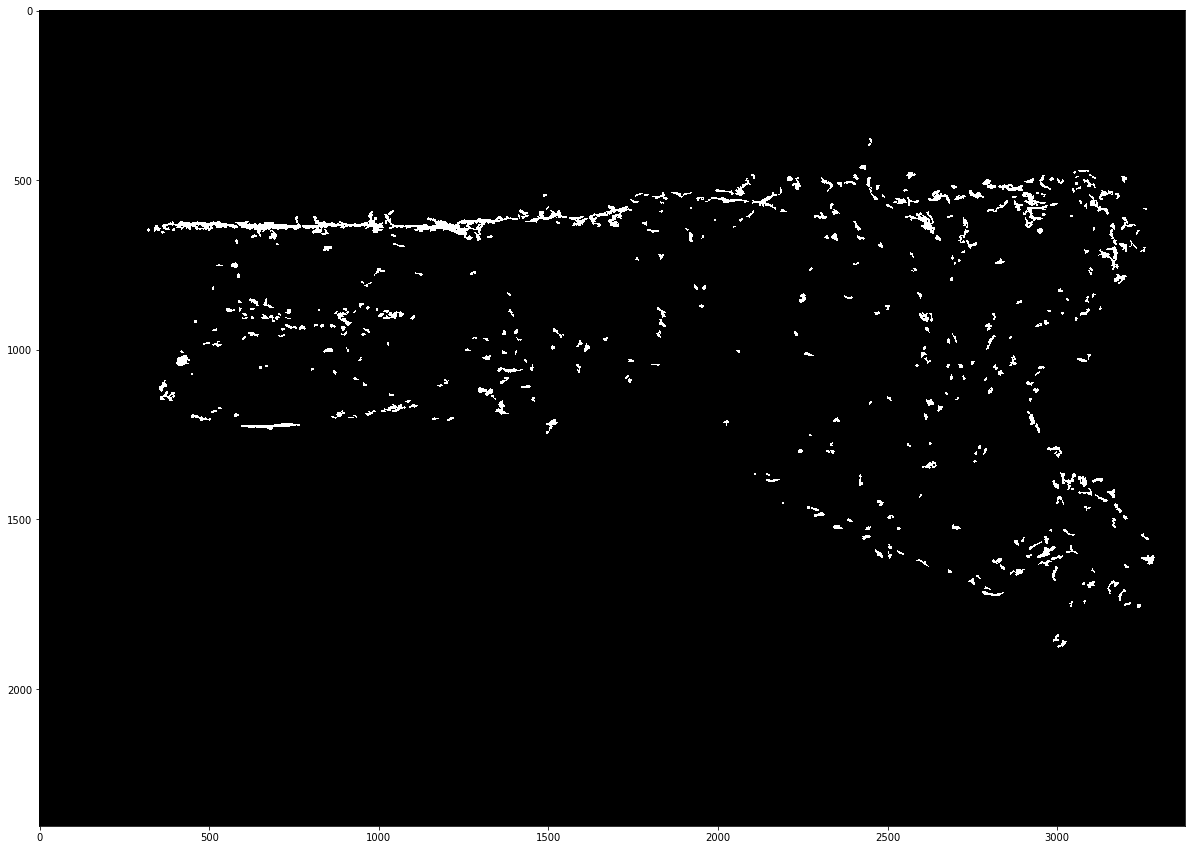

In [38]:
diff_binarized = 2000 * (diff_smalls_filtered_out > 0)
plt.figure(figsize=(30,15))
cle.imshow(diff_binarized, labels=False)

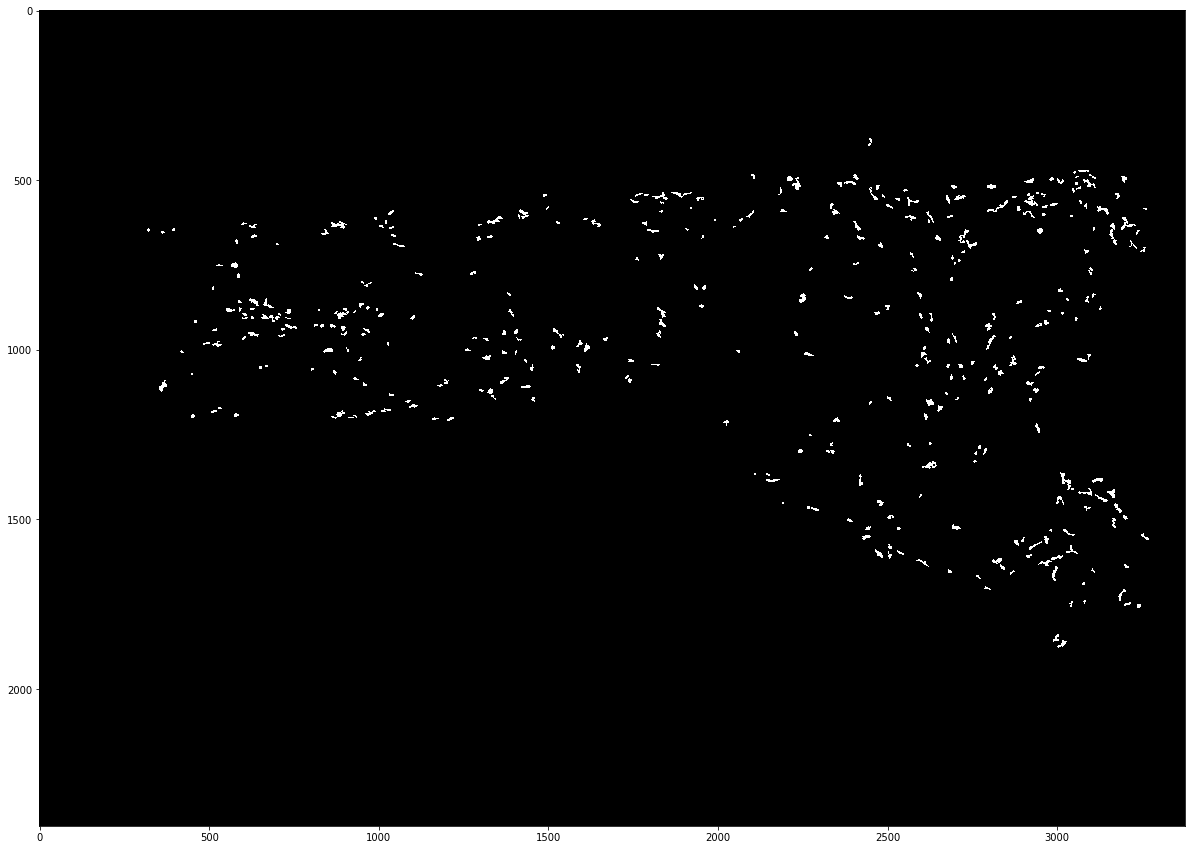

In [39]:
diff_binarized_x2 = 2000 * (diff_smalls_filtered_out_x2 > 0)
plt.figure(figsize=(30,15))
cle.imshow(diff_binarized_x2, labels=False)

In [40]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(diff_binarized), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(8, 76, 2404, 3376)
uint16


In [41]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(diff_binarized_x2), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(9, 76, 2404, 3376)
uint16


In [42]:
total_image = np.concatenate((total_image, np.expand_dims(mask, axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(10, 76, 2404, 3376)
uint16


In [43]:
# viewer.save_as_tif_sequence(total_image, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/FV10__20190620_111343_10-channel")

Obtain distance mesh
----------------------------------

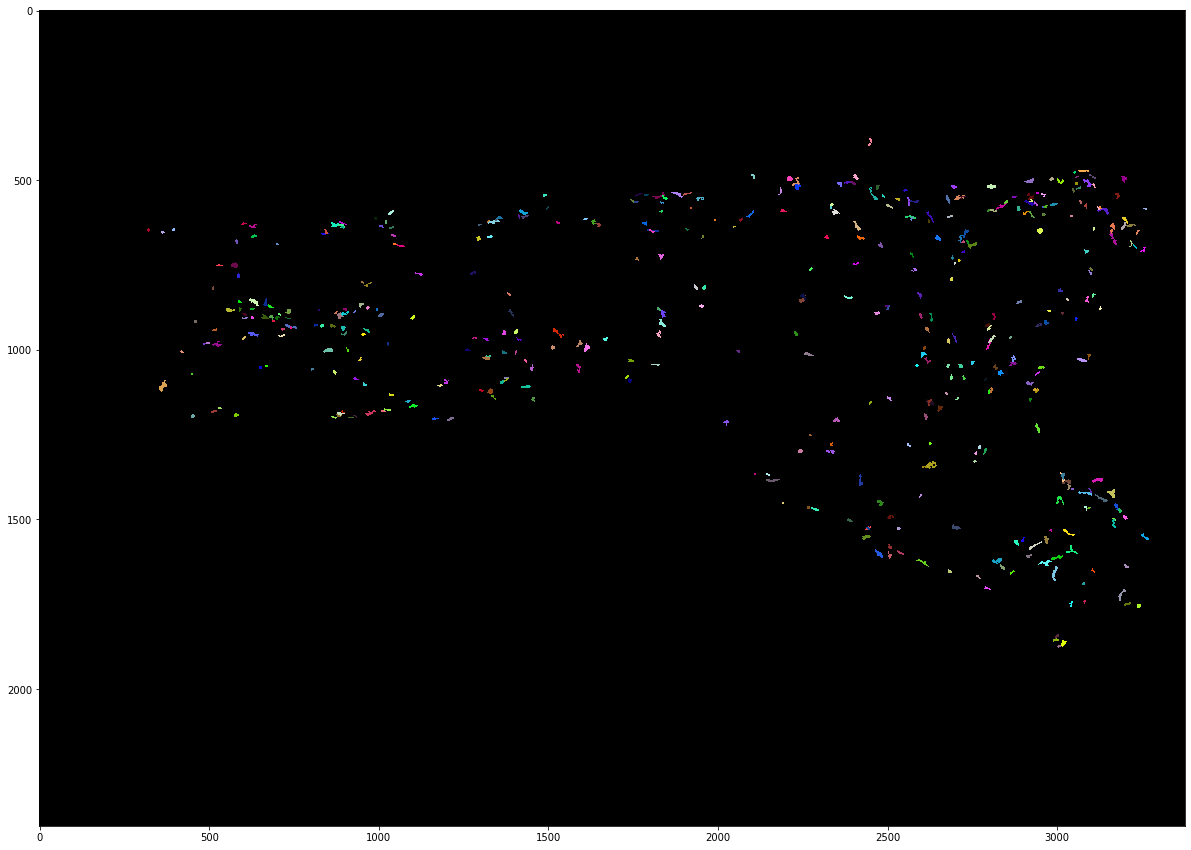

In [44]:
diff_smalls_filtered_out_x2.shape
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out_x2, labels=True)

(76, 2404, 3376)


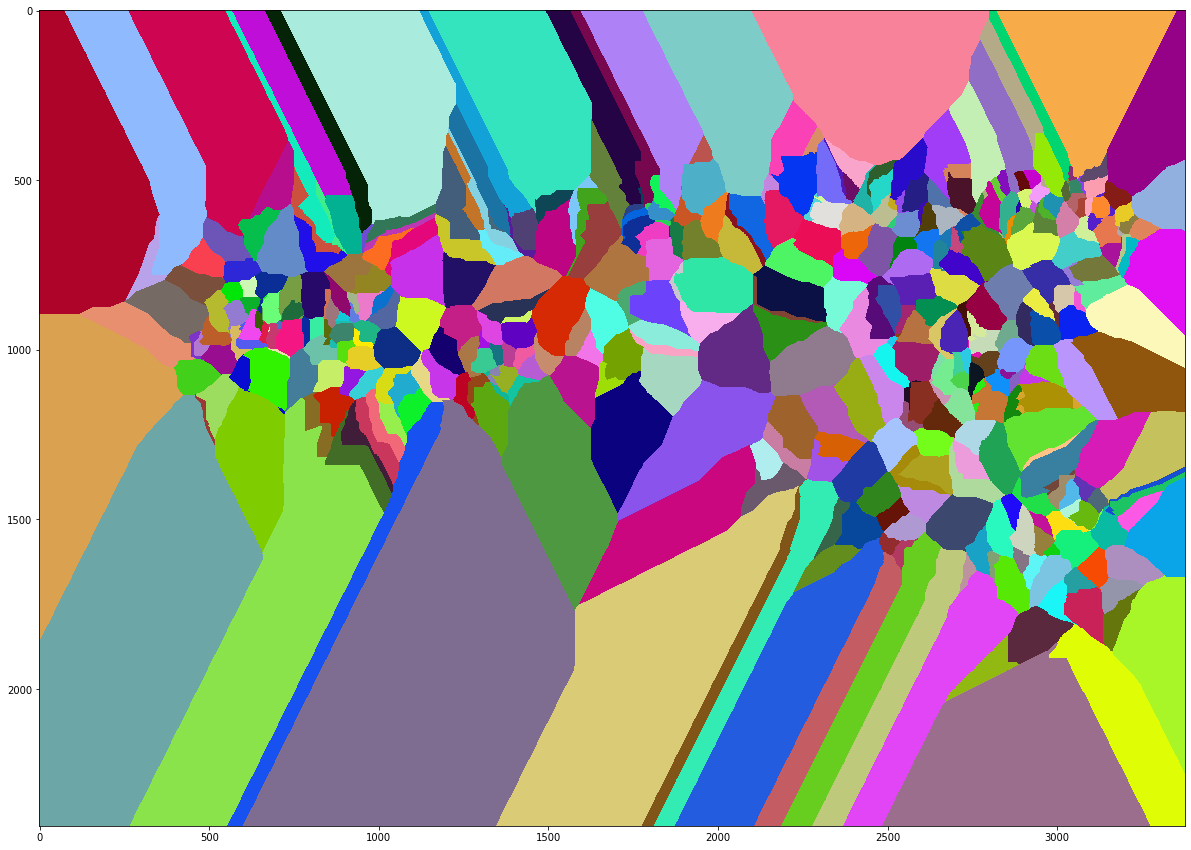

In [45]:
ng2_voronai = cle.extend_labeling_via_voronoi(diff_smalls_filtered_out_x2)
print(ng2_voronai.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_voronai, labels=True)

(440, 440)


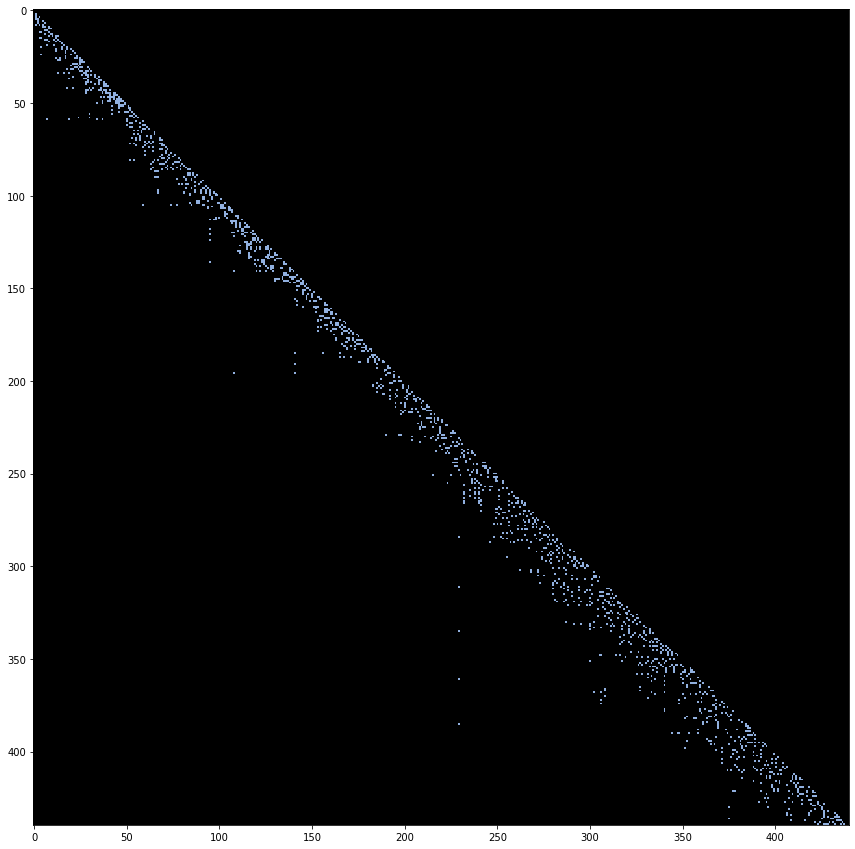

In [46]:
ng2_touch_matrix = cle.generate_touch_matrix(ng2_voronai)
print(ng2_touch_matrix.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_matrix, labels=True)

In [47]:
ng2_centroids = cle.centroids_of_labels(diff_smalls_filtered_out_x2)
print(ng2_centroids.shape)
print(ng2_centroids)
print(type(ng2_centroids))

(3, 439)
[[3.2146835e+02 3.6559433e+02 3.6405130e+02 ... 3.2533035e+03
  3.2581887e+03 3.2593735e+03]
 [6.4767407e+02 1.1061930e+03 6.5434619e+02 ... 7.0484747e+02
  1.5531040e+03 5.8503229e+02]
 [4.8860760e+00 2.2335587e+00 2.8685899e+00 ... 6.3875786e+01
  7.3659607e+01 6.9231186e+01]]
<class 'pyclesperanto_prototype._tier0._pycl.OCLArray'>


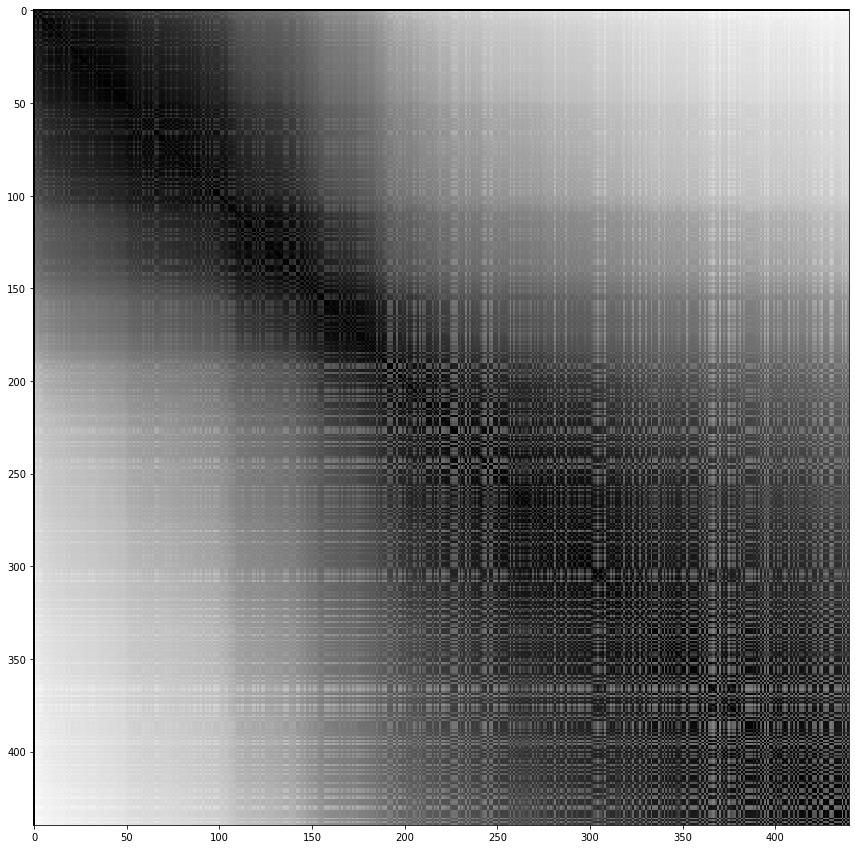

In [48]:
# NG2 distance matrix
ng2_distance_matrix = cle.generate_distance_matrix(ng2_centroids, ng2_centroids)

plt.figure(figsize=(30,15))
cle.imshow(ng2_distance_matrix, labels=False)

(440, 440)
(440, 440)


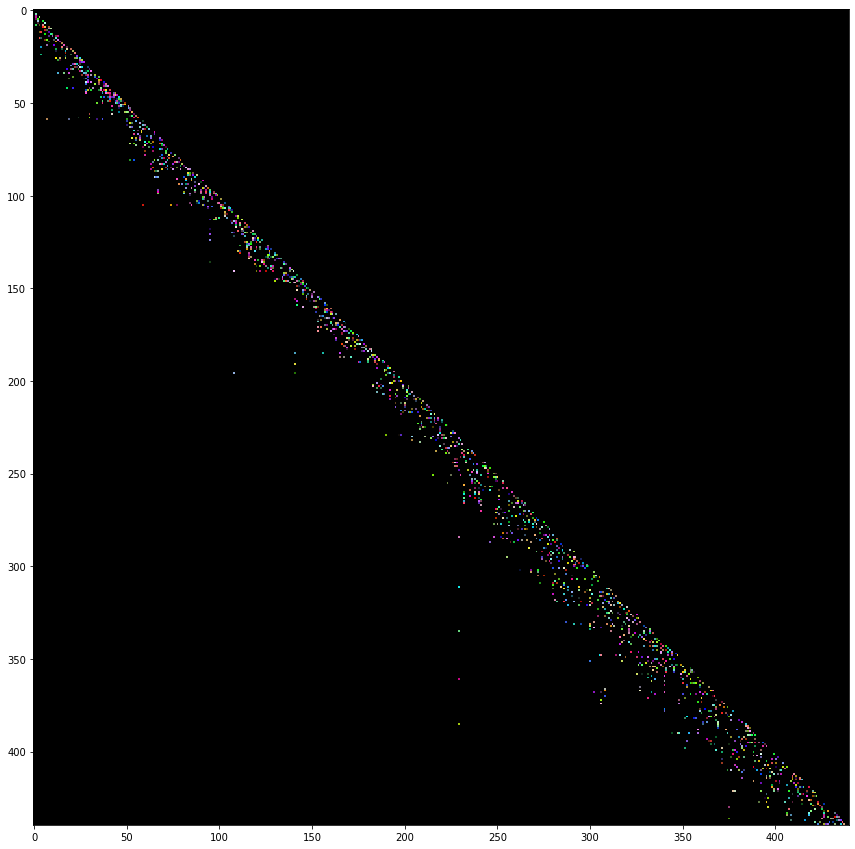

In [49]:
print(ng2_touch_matrix.shape)
print(ng2_distance_matrix.shape)

ng2_touch_distance_matrix = cle.multiply_images(ng2_touch_matrix, ng2_distance_matrix)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_distance_matrix, labels=True)

(75, 1875, 3260)


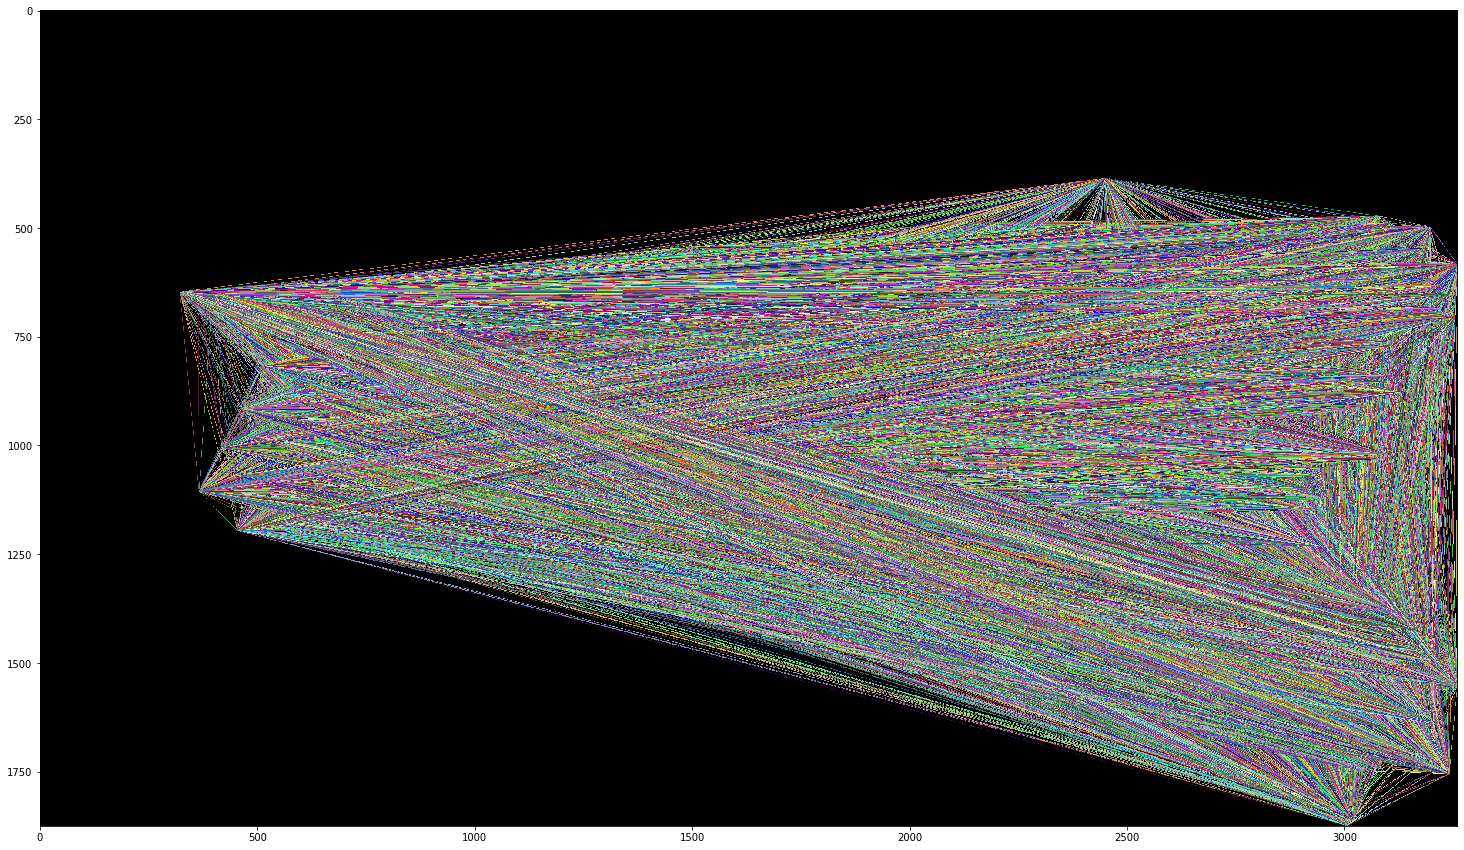

In [50]:
ng2_distance_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_distance_matrix)
print(ng2_distance_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_distance_mesh, labels=True)

(75, 1875, 3260)


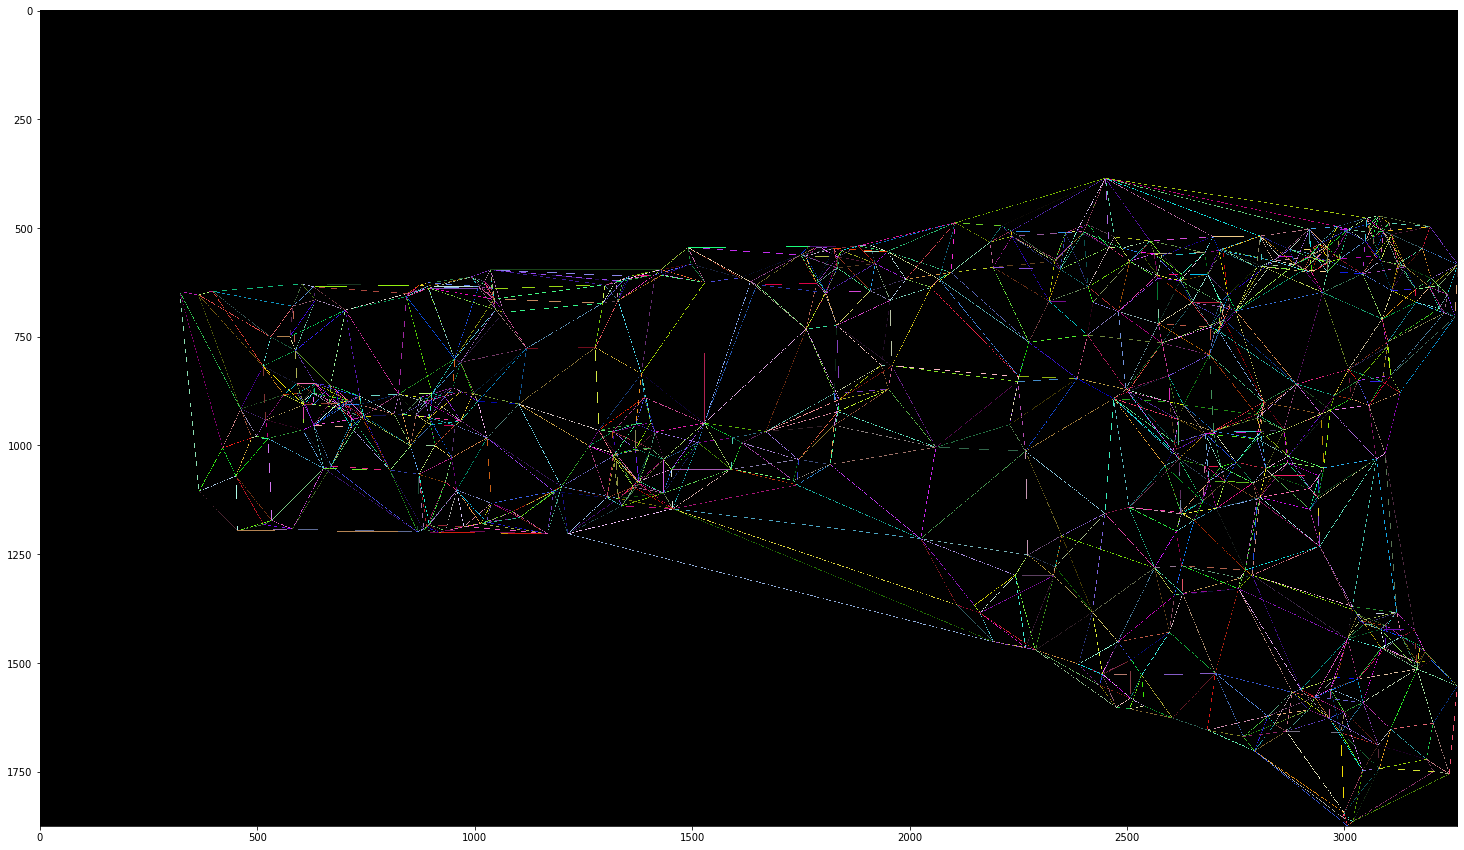

In [51]:
ng2_touch_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_touch_distance_matrix)
print(ng2_touch_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_mesh, labels=True)

In [52]:
ng2_touch_distance_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_touch_distance_matrix)
print(ng2_touch_distance_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_distance_mesh, labels=True)

MemoryError: clEnqueueNDRangeKernel failed: MEM_OBJECT_ALLOCATION_FAILURE

DTC Distance Analyses
---

In [ ]:
# NG2-tumor distance matrix
tumor_distance_matrix = cle.generate_distance_matrix(tumor_pointlist, tumor_pointlist)
plt.figure(figsize=(30,15))
cle.imshow(tumor_distance_matrix, labels=True)

In [ ]:
tumor_distance_mesh = cle.touch_matrix_to_mesh(tumor_pointlist, tumor_distance_matrix)
plt.figure(figsize=(30,15))
cle.imshow(tumor_distance_mesh, labels=True)

In [ ]:
# create DTC voronai and filter connects using touching neighbors

In [ ]:
# filter connects by those within a certain distance (vs just touching neighbors)

In [ ]:
# 2D spatial distribution analyses